<a href="https://colab.research.google.com/github/parment1/Project-M1-M2/blob/main/Copie_de_Module_1_%26_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from functools import reduce
from pandas.tseries.offsets import MonthEnd  
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from numpy import log
 

pd.set_option('display.max_rows',300)


Part I : Data acquisition, formating and cleaning

PART I project: Data acquisition, formating and cleaning

Dataset 1: Download the time series available on NASDAQ website for the Nasdaq Composite index, max history 2011 https://www.nasdaq.com/market-activity/index/ndx/historical

Dataset 2:

-GDP: We use GGP in percent change from preceding Period, quarterly, Seasonally Adjusted Annual Rate: Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-CPI (consumer price inflation): Consumer Price Index: Growth Rate Same Period Previous Year, Monthly, Not Seasonally Adjusted. Source: https://fred.stlouisfed.org/tags/series?t=quarterly

-US Interest rates: Effective Federal Funds Rates/FEDFUNDS

-US Unemployment rate Unemployment Rate, Percentfed.org/series/UNRATE

Problem: Do we see a relationship between the stock market and macroeconomic variables


In [ ]:
#Open each xls/csv
Nasdaq = pd.read_excel('/content/Nasdaq composite index.xlsx')
#CPI = Consumer price index
CPI = pd.read_excel('/content/CPI monthly.xls')
#Interest_rate = fed fund rate
Interest_rate = pd.read_excel('/content/Fed fund.xls')
GDP = pd.read_excel('/content/GDP.xls')
Unemployment = pd.read_excel('/content/Unemployment.xls')


Explore the strucutre of the different datasets. They all have different shape with monthly data for Unemployment CPI and interest rate, daily for Nasdaq and quarterly for GDP.

We add the monthly percentage change of the Nasdaq



In [ ]:
#check size of each dataset
print([Nasdaq.shape,CPI.shape,Interest_rate.shape,GDP.shape,Unemployment.shape])

[(2557, 6), (464, 2), (806, 2), (297, 2), (884, 2)]


In [ ]:
#Align the column name for all data set
Nasdaq = Nasdaq.rename(columns={'Date': 'observation_date'})

#Select columns Date & Close/Last date from Nasdaq dataset
Nasdaq = Nasdaq[['observation_date','Close/Last']]

#Get only monthly value for nadsqa (we can use either last day or first day of the month, need to be a trading day)
dates_month = pd.bdate_range(Nasdaq['observation_date'].min(), Nasdaq['observation_date'].max(), freq='1MS')

#Apply bdate range to the Nasdaq DF using isin
Nasdaq_mth = Nasdaq[Nasdaq['observation_date'].isin(dates_month)]
Nasdaq_mth.reset_index(inplace=True,drop=True)

#Calculate monthly return for the Nasdaq timeserie
Nasdaq_mth['Monthly return'] =  Nasdaq_mth['Close/Last'].pct_change()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Each dataset has a column "observation_date", with a different length. The maximum time length publicly available for download is 10 years, we do the following steps

1. we adjust the other data frame to this timeframe for each DF
2. Check the new shape of each DF
3. Merge the different DF into one
4. Simplify the name of the columns

In [ ]:
#Select observation period, adjust starting/ending value for different periods

starting_date = '2012-01-01'
ending_date = '2019-12-01'

#Function to select obeservation period, df = dataframe

def select_date(df):
  x = df[(df['observation_date'] >= starting_date) & (df['observation_date'] <= ending_date)]
  x.reset_index(inplace=True,drop=True)
  return x

#Apply to the different dataframe using pipe and create new DF with selected time period
Nasdaq_sample, Interest_rate_sample, CPI_sample, GDP_sample,Unemployment_sample = (df.pipe(select_date)for df in [Nasdaq_mth, Interest_rate,CPI, GDP,Unemployment])


In [ ]:
#Check size of dataset after transformation
print([Nasdaq_sample.shape,CPI_sample.shape,Interest_rate_sample.shape,GDP_sample.shape,Unemployment_sample.shape])

[(95, 3), (96, 2), (96, 2), (32, 2), (96, 2)]


In [ ]:
data_frames = [Nasdaq_sample,CPI_sample,Interest_rate_sample,Unemployment_sample,GDP_sample]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames)

#drop the column Close/Last and set "observation date" as index
df_merged = df_merged.drop('Close/Last', axis = 1)
df_merged_clean = df_merged.set_index('observation_date')

#fillna 
df_merged_clean = df_merged_clean.fillna(method='bfill')

#See column name
columns = df_merged_clean.columns
columns

Index(['Monthly return', 'CPI', 'Effective Federal Funds Rate',
       'Unemployment Rate, Percent', 'Gross Domestic Product'],
      dtype='object')

In [ ]:
df_merged_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2019-12-01 to 2012-01-01
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly return                95 non-null     float64
 1   CPI                           95 non-null     float64
 2   Effective Federal Funds Rate  95 non-null     float64
 3   Unemployment Rate, Percent    95 non-null     float64
 4   Gross Domestic Product        95 non-null     float64
dtypes: float64(5)
memory usage: 4.5 KB


In [ ]:
df_merged_clean.isna().sum()


Monthly return                  0
CPI                             0
Effective Federal Funds Rate    0
Unemployment Rate, Percent      0
Gross Domestic Product          0
dtype: int64


Part II: Descriptive analysis

-Check how dataset looks like
-Plot the different dataset
-Correlation matrix
-Cointegration matrix
-Test

Check how the data are distrbitued with  a kernel density estimate to smooth the histogram



In [ ]:
df_columns = df_merged_clean.columns
df_merged_clean.head(20)


,Monthly return,CPI,Effective Federal Funds Rate,"Unemployment Rate, Percent",Gross Domestic Product
observation_date,,,,,
2019-12-01,-0.063452,1.999222,1.55,3.6,3.6
2019-11-01,-0.017822,2.960686,1.55,3.6,3.6
2019-10-01,-0.058451,2.702275,1.83,3.6,3.6
2019-09-01,-0.009712,3.150655,2.04,3.5,4.1
2019-08-01,0.025184,2.625757,2.13,3.7,4.1
2019-07-01,-0.004231,2.617853,2.40,3.6,4.1
2019-06-01,-0.101713,3.974728,2.38,3.6,5.6
2019-05-01,0.110895,2.558535,2.39,3.7,5.6
2019-04-01,-0.035273,3.167588,2.42,3.7,5.6


Text(0.5, 1.0, 'Unemployment rate %')

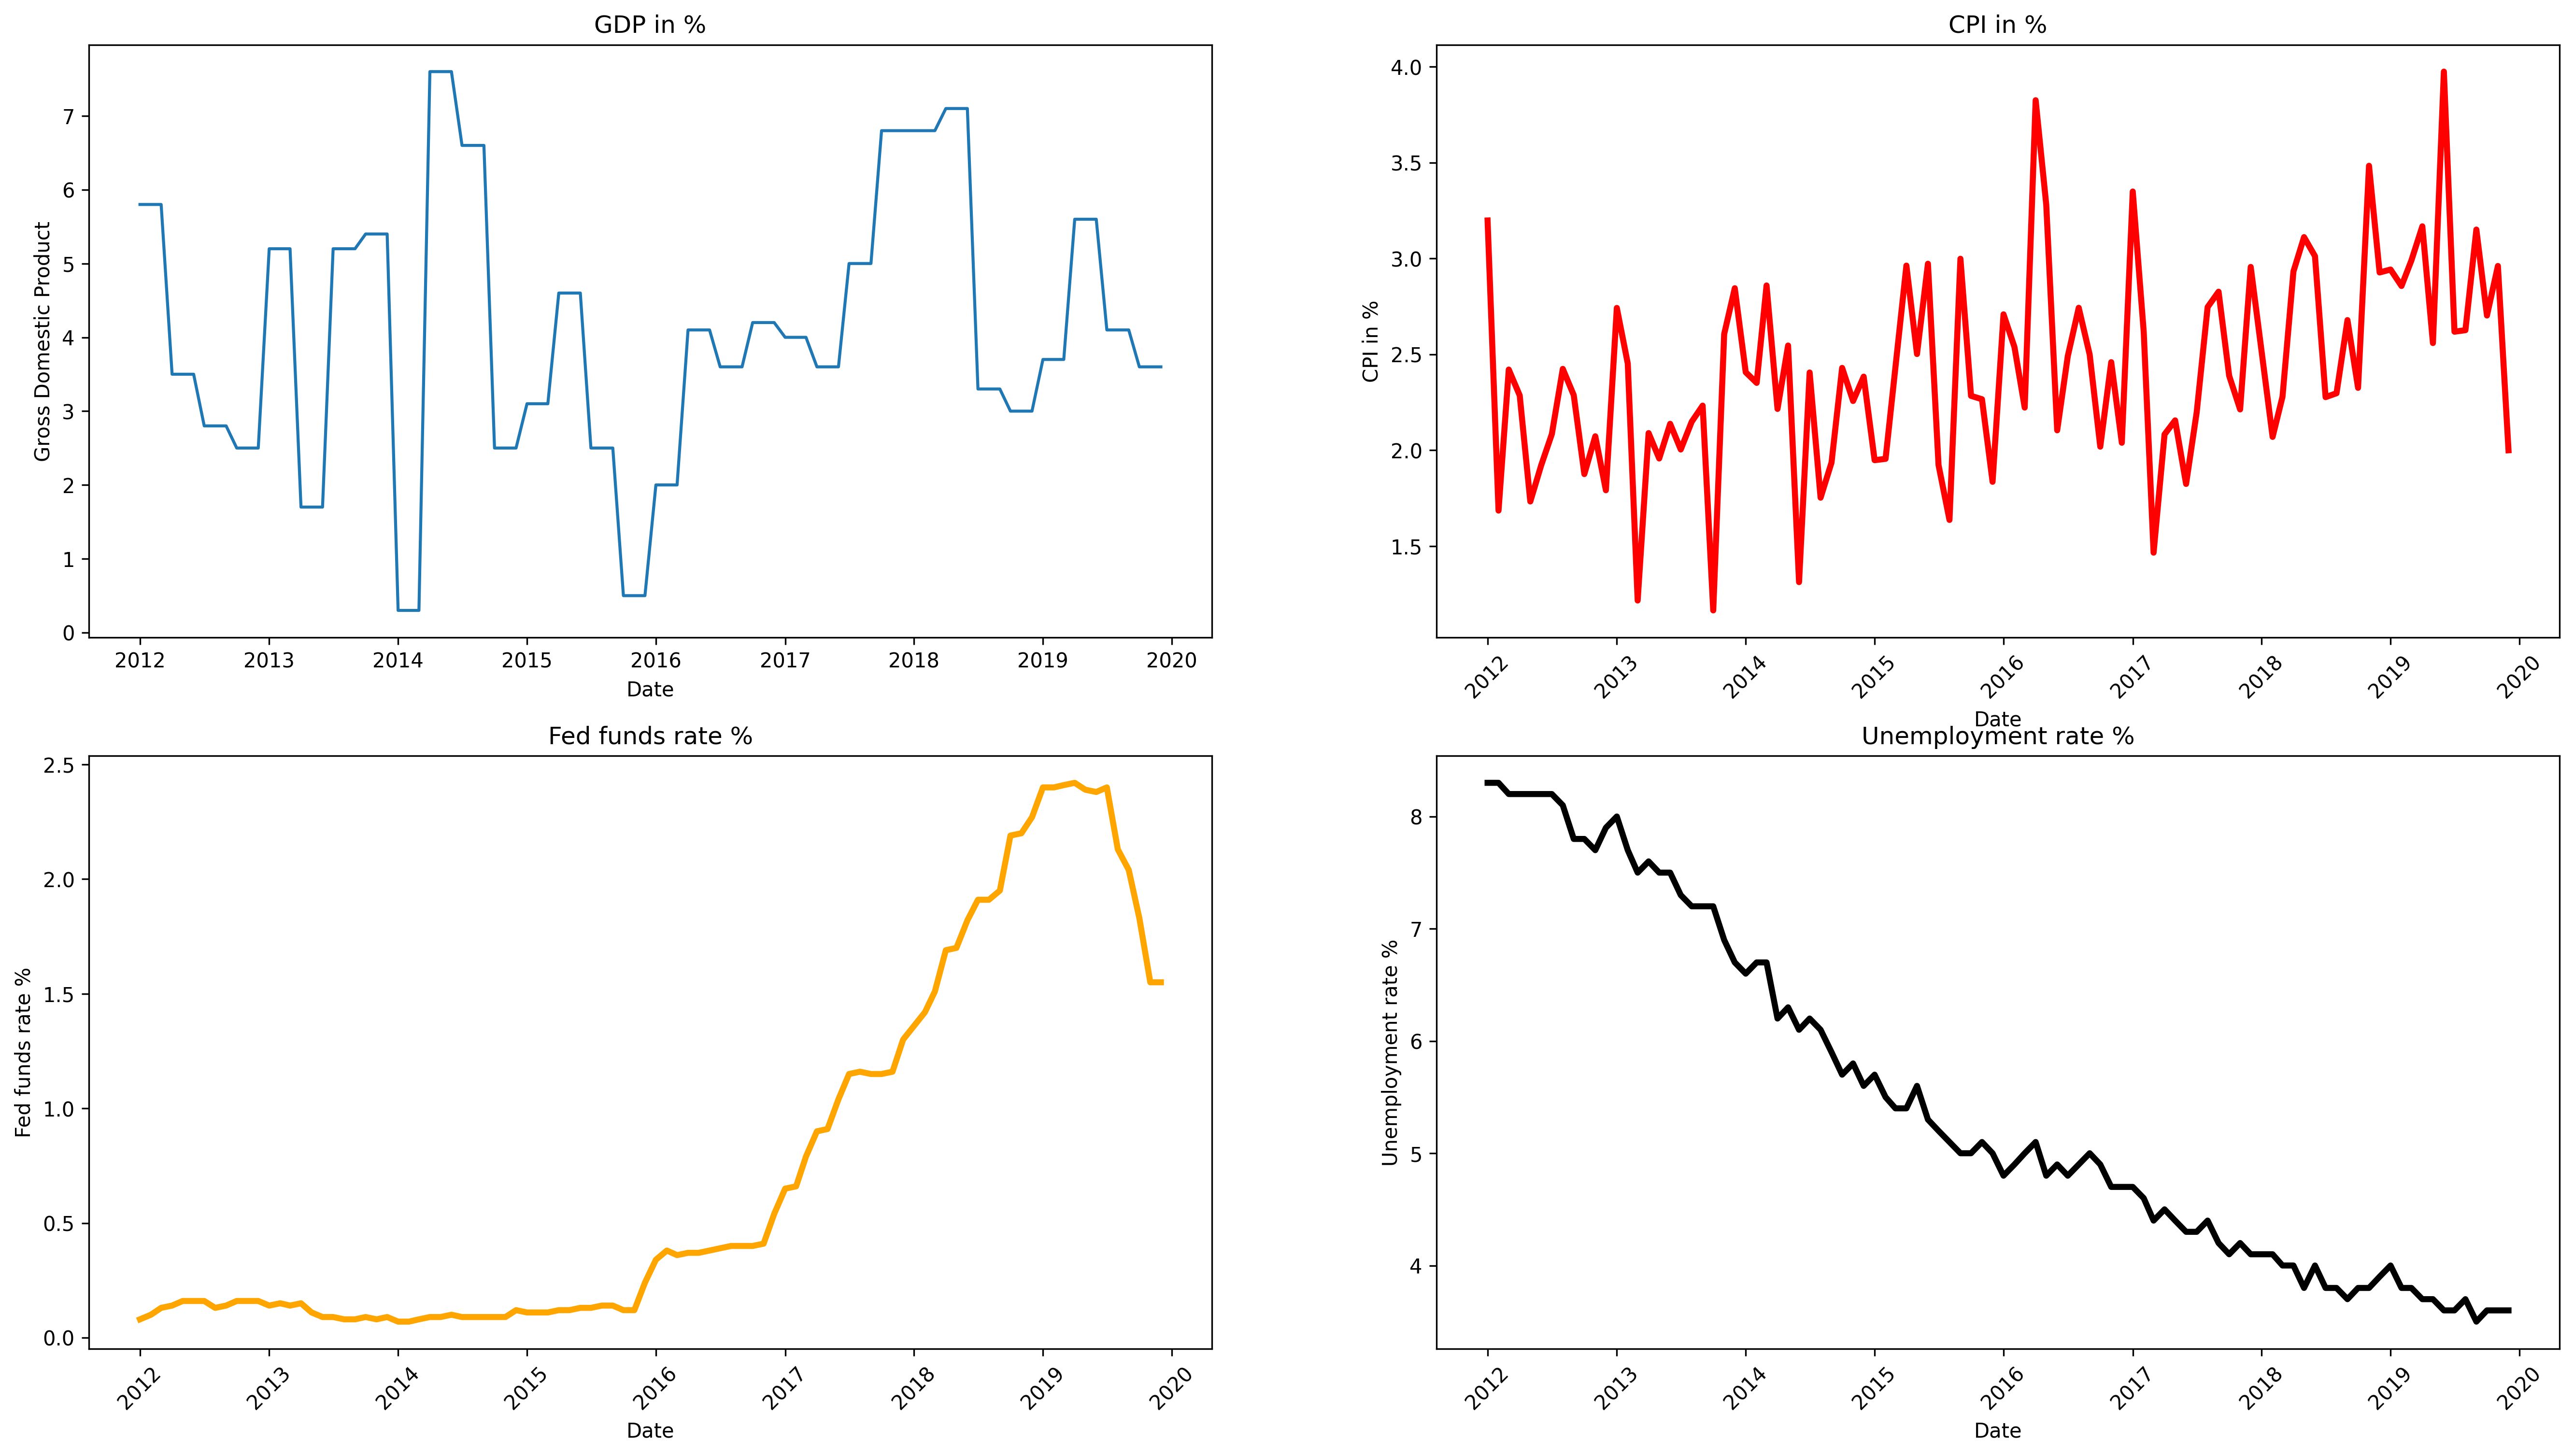

In [ ]:
# Line plots
fig1 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig1.add_subplot(221)
sns.lineplot(
    data=df_merged_clean, 
#     kind="line",
    x=df_merged_clean.index, 
    y="Gross Domestic Product")
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig1.add_subplot(222)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="CPI",
    ax = ax2,
    linewidth = 3,
    color = 'red')
plt.xticks(rotation=45) 
plt.ylabel('CPI in %')
plt.xlabel('Date')
plt.title('CPI in %')

ax3 = fig1.add_subplot(223)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Effective Federal Funds Rate",
    ax = ax3,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Fed funds rate %')
plt.xlabel('Date')
plt.title('Fed funds rate %')

ax4 = fig1.add_subplot(224)
sns.lineplot(
    data=df_merged_clean, 
    x=df_merged_clean.index, 
    y="Unemployment Rate, Percent",
    ax = ax4,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')



In [ ]:
round(df_merged_clean.describe(),2)

,Monthly return,CPI,Effective Federal Funds Rate,"Unemployment Rate, Percent",Gross Domestic Product
count,95.00,95.00,95.00,95.00,95.00
mean,-0.01,2.42,0.72,5.47,4.04
std,0.04,0.52,0.81,1.53,1.79
min,-0.11,1.16,0.07,3.50,0.30
25%,-0.04,2.08,0.12,4.10,2.90
50%,-0.02,2.39,0.24,5.00,3.70
75%,0.01,2.74,1.23,6.70,5.20
max,0.11,3.97,2.42,8.30,7.60


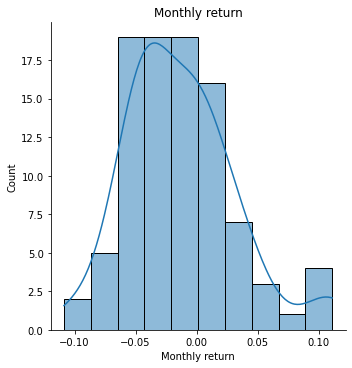

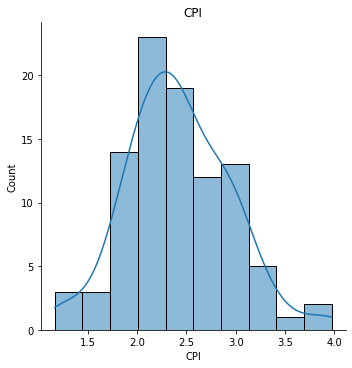

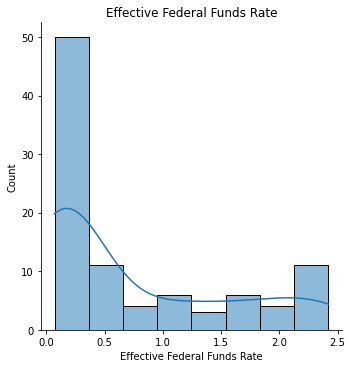

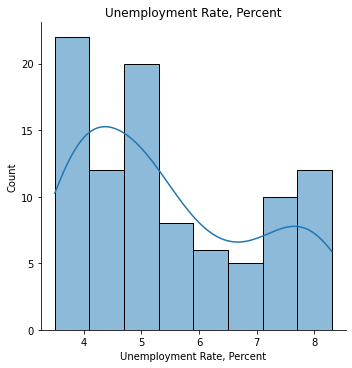

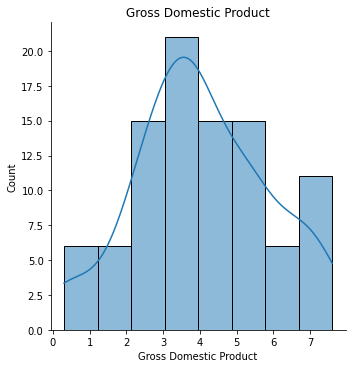

In [ ]:
#Visualisation data distribution
for i in df_columns:
  sns.displot(df_merged_clean, x=i,kde=True)
  plt.title(i)

In [ ]:
#Check skweness
df_merged_clean.skew()

Monthly return                  0.732748
CPI                             0.272280
Effective Federal Funds Rate    1.000522
Unemployment Rate, Percent      0.524234
Gross Domestic Product          0.039066
dtype: float64

In [ ]:
#Check Kurtosis
df_merged_clean.apply(pd.DataFrame.kurt)

Monthly return                  0.831503
CPI                             0.482423
Effective Federal Funds Rate   -0.552550
Unemployment Rate, Percent     -1.079517
Gross Domestic Product         -0.367283
dtype: float64

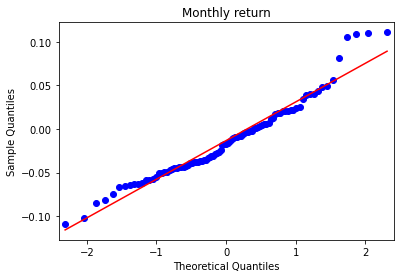

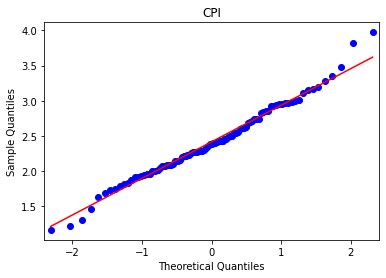

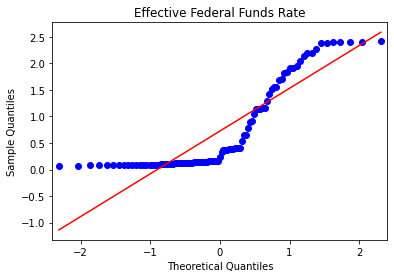

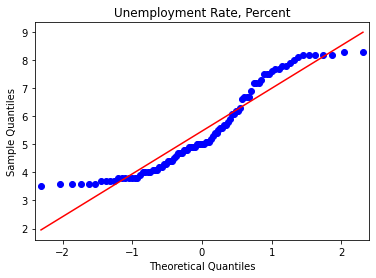

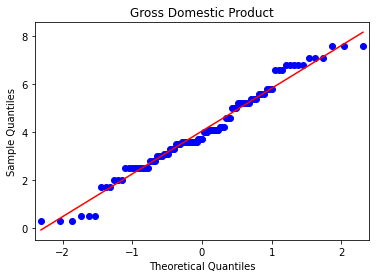

In [ ]:
#checking the distribution of a data sample iwiths the quantile-quantile plot, Q-Q plot
for i in df_columns:
  qqplot(df_merged_clean[i], line='s')
  plt.title(i)
  plt.show()


Perform various tests to check if the distribution is Gaussian:

- Shapiro Wilk Test
- D'Agostino and Pearson's Test
- Anderson test


In [ ]:
# Shapiro-Wilk Test for Gaussian distribution
print('Shapiro-Wilk test')
for i in df_columns: 
  stat, p = shapiro(df_merged_clean[i])
  print(' ')
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
    print(i + ' Sample looks Gaussian (fail to reject H0)')
  else:
    print(i + ' Sample does not look Gaussian (reject H0)')


Shapiro-Wilk test
 
Statistics=0.958, p=0.004
Monthly return Sample does not look Gaussian (reject H0)
 
Statistics=0.988, p=0.557
CPI Sample looks Gaussian (fail to reject H0)
 
Statistics=0.762, p=0.000
Effective Federal Funds Rate Sample does not look Gaussian (reject H0)
 
Statistics=0.901, p=0.000
Unemployment Rate, Percent Sample does not look Gaussian (reject H0)
 
Statistics=0.973, p=0.045
Gross Domestic Product Sample does not look Gaussian (reject H0)


In [ ]:
# D'Agostino and Pearson's Test  for Gaussian distribution
print("D'Agostino and Pearson's Test")
for i in df_columns: 
  stat, p = normaltest(df_merged_clean[i])
  print(' ')
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
    print(i + ' Sample looks Gaussian (fail to reject H0)')
  else:
    print(i + ' Sample does not look Gaussian (reject H0)')

D'Agostino and Pearson's Test
 
Statistics=10.286, p=0.006
Monthly return Sample does not look Gaussian (reject H0)
 
Statistics=2.392, p=0.302
CPI Sample looks Gaussian (fail to reject H0)
 
Statistics=15.016, p=0.001
Effective Federal Funds Rate Sample does not look Gaussian (reject H0)
 
Statistics=23.160, p=0.000
Unemployment Rate, Percent Sample does not look Gaussian (reject H0)
 
Statistics=0.581, p=0.748
Gross Domestic Product Sample looks Gaussian (fail to reject H0)


In [ ]:
# Anderson Test for Gaussian distribution
for i in df_columns: 
  result = anderson(df_merged_clean[i])
  print(' ')
  print(i + ' Statistic: %.3f' % result.statistic)
  p = 0
  for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
      print(' %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
      print(' %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

 
Monthly return Statistic: 1.005
 15.000: 0.554, data does not look normal (reject H0)
 10.000: 0.631, data does not look normal (reject H0)
 5.000: 0.757, data does not look normal (reject H0)
 2.500: 0.883, data does not look normal (reject H0)
 1.000: 1.051, data looks normal (fail to reject H0)
 
CPI Statistic: 0.334
 15.000: 0.554, data looks normal (fail to reject H0)
 10.000: 0.631, data looks normal (fail to reject H0)
 5.000: 0.757, data looks normal (fail to reject H0)
 2.500: 0.883, data looks normal (fail to reject H0)
 1.000: 1.051, data looks normal (fail to reject H0)
 
Effective Federal Funds Rate Statistic: 9.411
 15.000: 0.554, data does not look normal (reject H0)
 10.000: 0.631, data does not look normal (reject H0)
 5.000: 0.757, data does not look normal (reject H0)
 2.500: 0.883, data does not look normal (reject H0)
 1.000: 1.051, data does not look normal (reject H0)
 
Unemployment Rate, Percent Statistic: 3.012
 15.000: 0.554, data does not look normal (rejec

The Kruskal-Wallis test is a nonparametric version of the one-way analysis of variance test or ANOVA for short. It is named for the developers of the method, William Kruskal and Wilson Wallis. This test can be used to determine whether more than two independent samples have a different distribution. It can be thought of as the generalization of the Mann-Whitney U test.

In [ ]:

stat, p = kruskal(df_merged_clean['Monthly return'], 
                  df_merged_clean['CPI'], 
                  df_merged_clean['Effective Federal Funds Rate'],
                  df_merged_clean['Unemployment Rate, Percent'],
                  df_merged_clean['Gross Domestic Product'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=404.939, p=0.000
Different distributions (reject H0)


The Friedman test is the nonparametric version of the repeated measures analysis of variance test, or repeated measures ANOVA. The test can be thought of as a generalization of the Kruskal-Wallis H Test to more than two samples.

In [ ]:
stat, p = friedmanchisquare(df_merged_clean['Monthly return'], 
                  df_merged_clean['CPI'], 
                  df_merged_clean['Effective Federal Funds Rate'],
                  df_merged_clean['Unemployment Rate, Percent'],
                  df_merged_clean['Gross Domestic Product'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=352.306, p=0.000
Different distributions (reject H0)


In [ ]:
"""dict = {'Monthly return': 'Monthly return',
        'CPI':'CPI',
        'Effective Federal Funds Rate': 'Interest rates',
        'Unemployment Rate, Percent': 'Uneployment rate',
        'Gross Domestic Product':'GDP'
        }

# call rename () method
df_merged_clean.rename(columns=dict,
          inplace=True)"""

"dict = {'Monthly return': 'Monthly return',\n        'CPI':'CPI',\n        'Effective Federal Funds Rate': 'Interest rates',\n        'Unemployment Rate, Percent': 'Uneployment rate',\n        'Gross Domestic Product':'GDP'\n        }\n\n# call rename () method\ndf_merged_clean.rename(columns=dict,\n          inplace=True)"

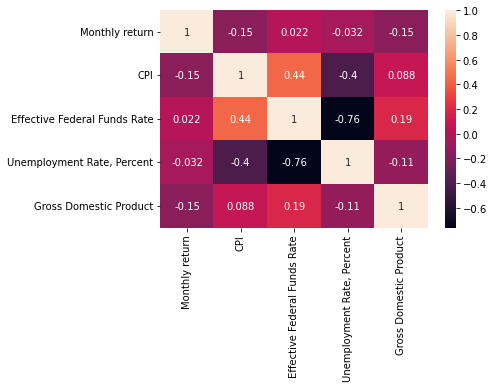

In [ ]:
corrMatrix = df_merged_clean.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Test for stationarity with The Augmented Dickey-Fuller **test**



In [ ]:
for i in df_columns:
  X = df_merged_clean[i].values
  result = adfuller(X)
  print(i)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))

Monthly return
ADF Statistic: -7.073165
p-value: 0.000000
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584
CPI
ADF Statistic: -7.723859
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Effective Federal Funds Rate
ADF Statistic: -4.636873
p-value: 0.000110
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
Unemployment Rate, Percent
ADF Statistic: 0.748050
p-value: 0.990750
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585
Gross Domestic Product
ADF Statistic: -2.384516
p-value: 0.146154
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


log transform the dataset again to make the distribution of values more linear and better meet the expectations of this statistical test.**texte en gras**

In [ ]:
for i in df_columns:
  X = df_merged_clean[i].values
  X = log(X)
  X = X[np.logical_not(np.isnan(X))]
  result = adfuller(X)
  print(i + ' ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))



Monthly return ADF Statistic: -3.828465
p-value: 0.002629
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621
CPI ADF Statistic: -8.035787
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Effective Federal Funds Rate ADF Statistic: -0.633733
p-value: 0.863176
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584
Unemployment Rate, Percent ADF Statistic: 0.497219
p-value: 0.984788
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584
Gross Domestic Product ADF Statistic: -2.514481
p-value: 0.111991
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Make the DF stationariy for the columns where H0 is rejected
columns = ['Effective Federal Funds Rate','Unemployment Rate, Percent'	,'Gross Domestic Product']
df_merged_clean_first_difference = df_merged_clean[columns].diff().dropna()



In [ ]:
df_columns_first_difference = df_merged_clean_first_difference.columns
display(df_columns_first_difference)
for i in df_columns_first_difference:
  X = df_merged_clean_first_difference[i].values
  X = X[np.logical_not(np.isnan(X))]
  result = adfuller(X)
  print(i + ' ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))

Index(['Effective Federal Funds Rate', 'Unemployment Rate, Percent',
       'Gross Domestic Product'],
      dtype='object')

Effective Federal Funds Rate ADF Statistic: -2.053135
p-value: 0.263772
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586
Unemployment Rate, Percent ADF Statistic: -3.033129
p-value: 0.031914
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585
Gross Domestic Product ADF Statistic: -7.691053
p-value: 0.000000
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


Text(0.5, 1.0, 'Unemployment rate %')

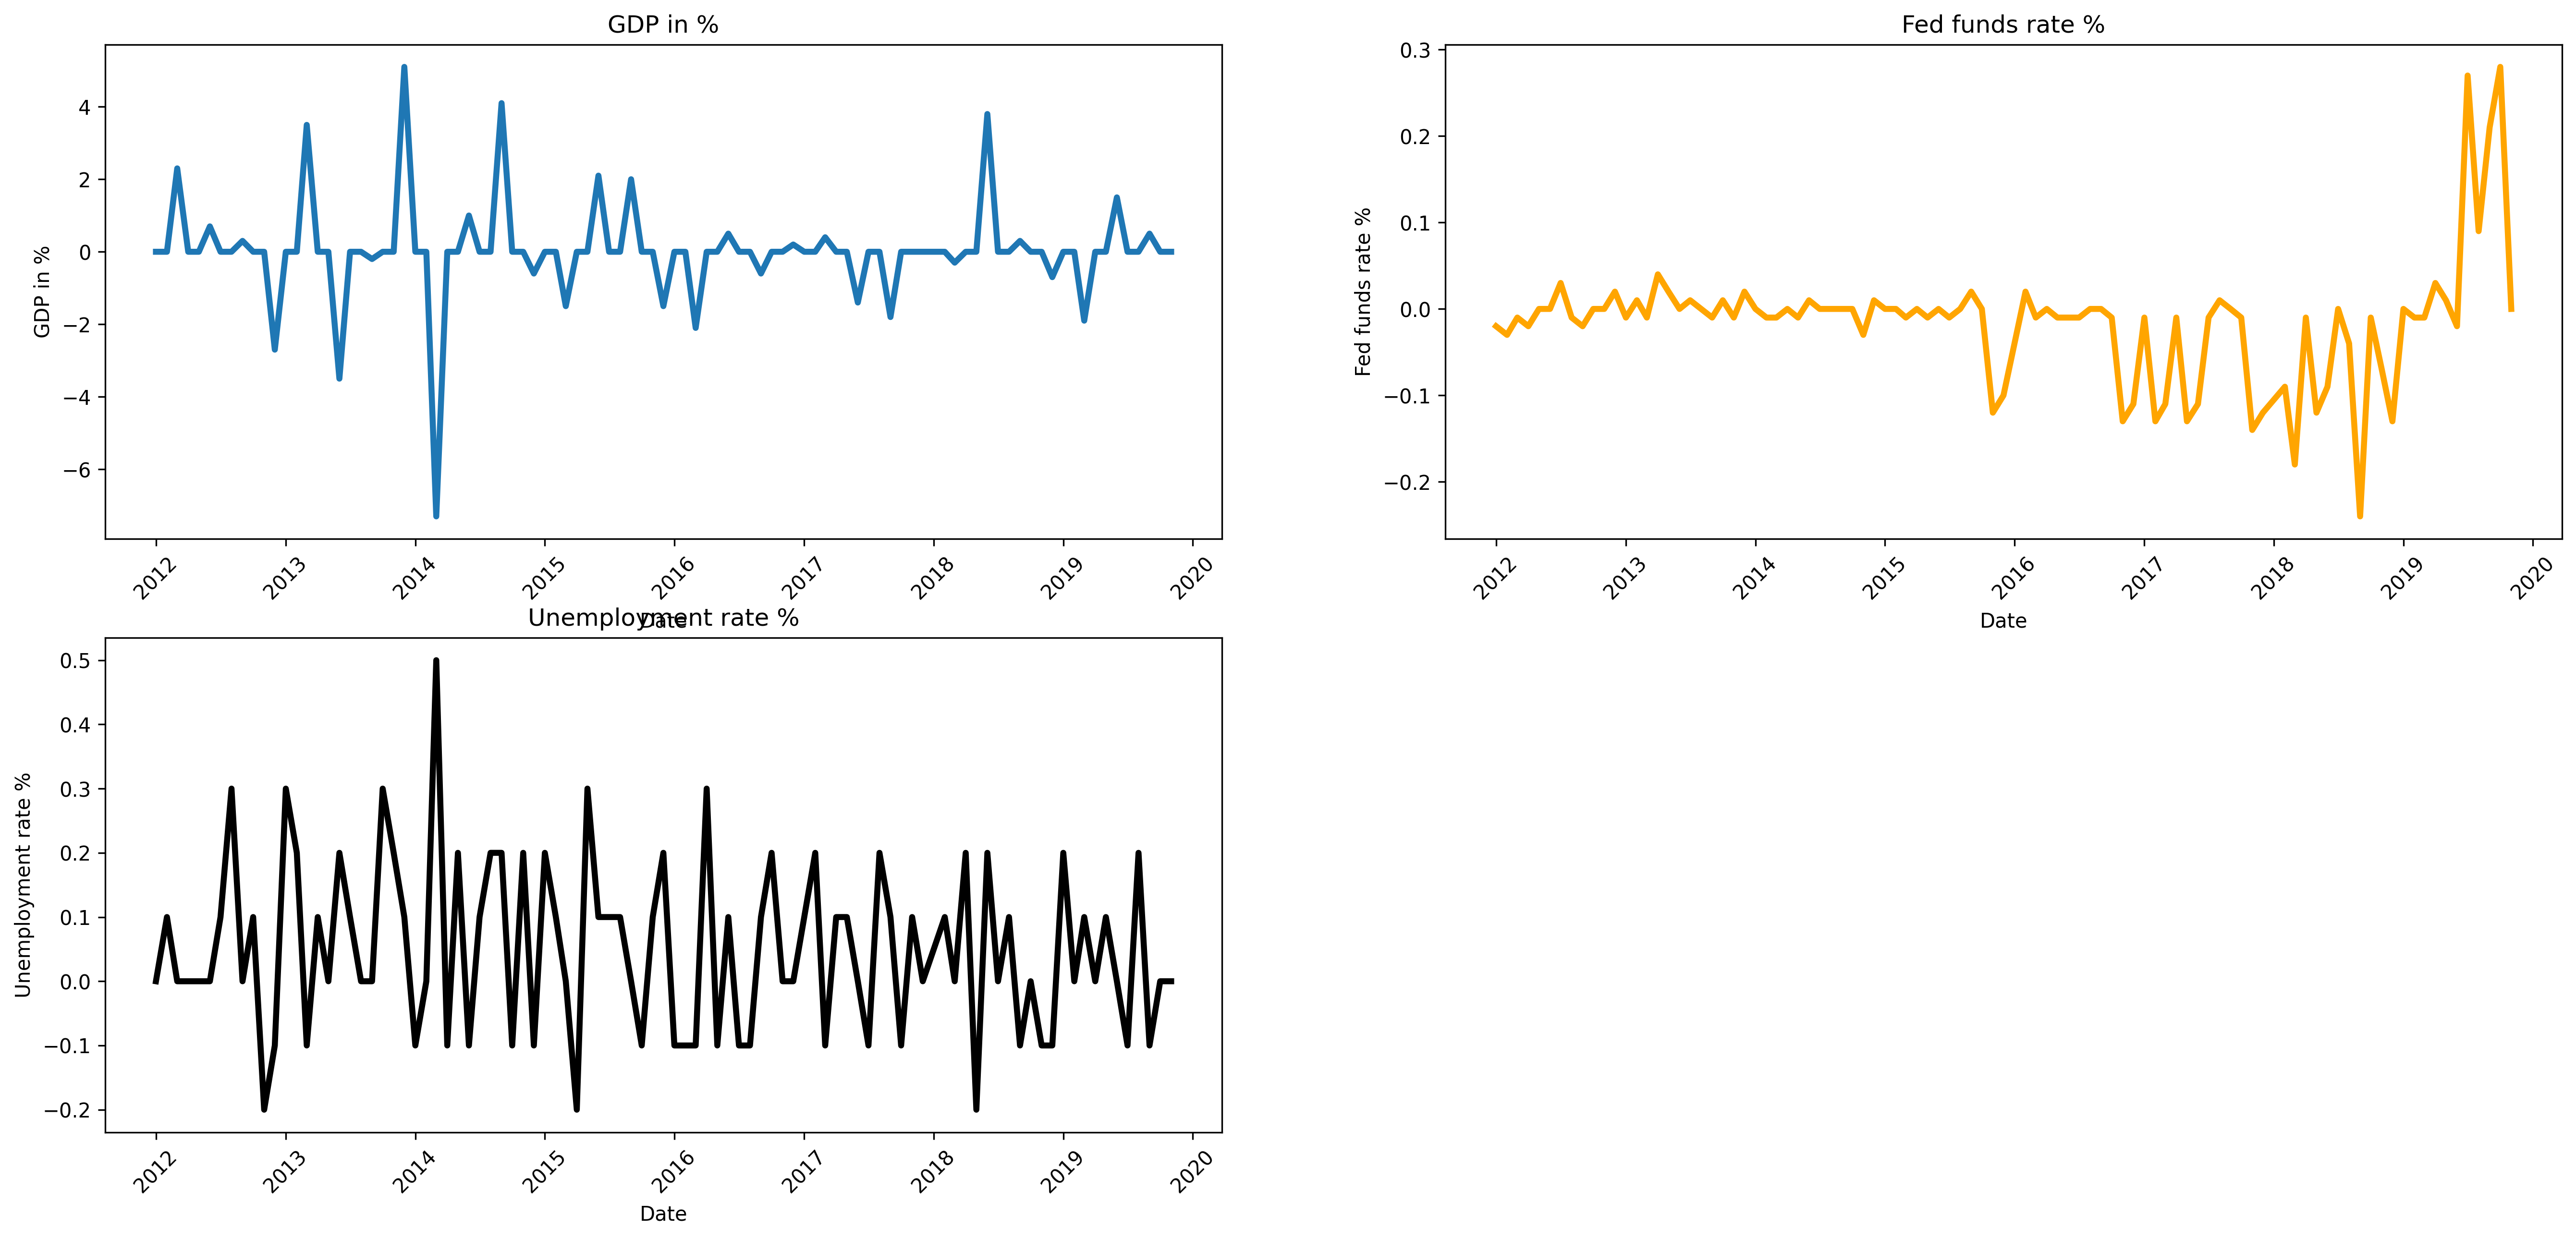

In [ ]:
# Line plots
fig2 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig2.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_first_difference, 
#     kind="line",
    x=df_merged_clean_first_difference.index, 
    y="Gross Domestic Product",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('GDP in %')
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig2.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Effective Federal Funds Rate",
    ax = ax2,
    linewidth = 3,
    color = 'orange')
plt.xticks(rotation=45) 
plt.ylabel('Fed funds rate %')
plt.xlabel('Date')
plt.title('Fed funds rate %')

ax3 = fig2.add_subplot(223)
sns.lineplot(
    data=df_merged_clean_first_difference, 
    x=df_merged_clean_first_difference.index, 
    y="Unemployment Rate, Percent",
    ax = ax3,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')


In [ ]:
columns_second = ['Unemployment Rate, Percent'	,'Gross Domestic Product']
df_merged_clean_second_difference = df_merged_clean_first_difference[columns_second].diff().dropna()


In [ ]:
df_columns_second_difference = df_merged_clean_second_difference.columns

for i in df_columns_second_difference:
  X = df_merged_clean_second_difference[i].values
  X = X[np.logical_not(np.isnan(X))]
  result = adfuller(X)
  print(i + ' ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))

Unemployment Rate, Percent ADF Statistic: -6.027529
p-value: 0.000000
Critical Values:
	1%: -3.512
	5%: -2.897
	10%: -2.586
Gross Domestic Product ADF Statistic: -6.636281
p-value: 0.000000
Critical Values:
	1%: -3.511
	5%: -2.897
	10%: -2.585


Text(0.5, 1.0, 'Unemployment rate %')

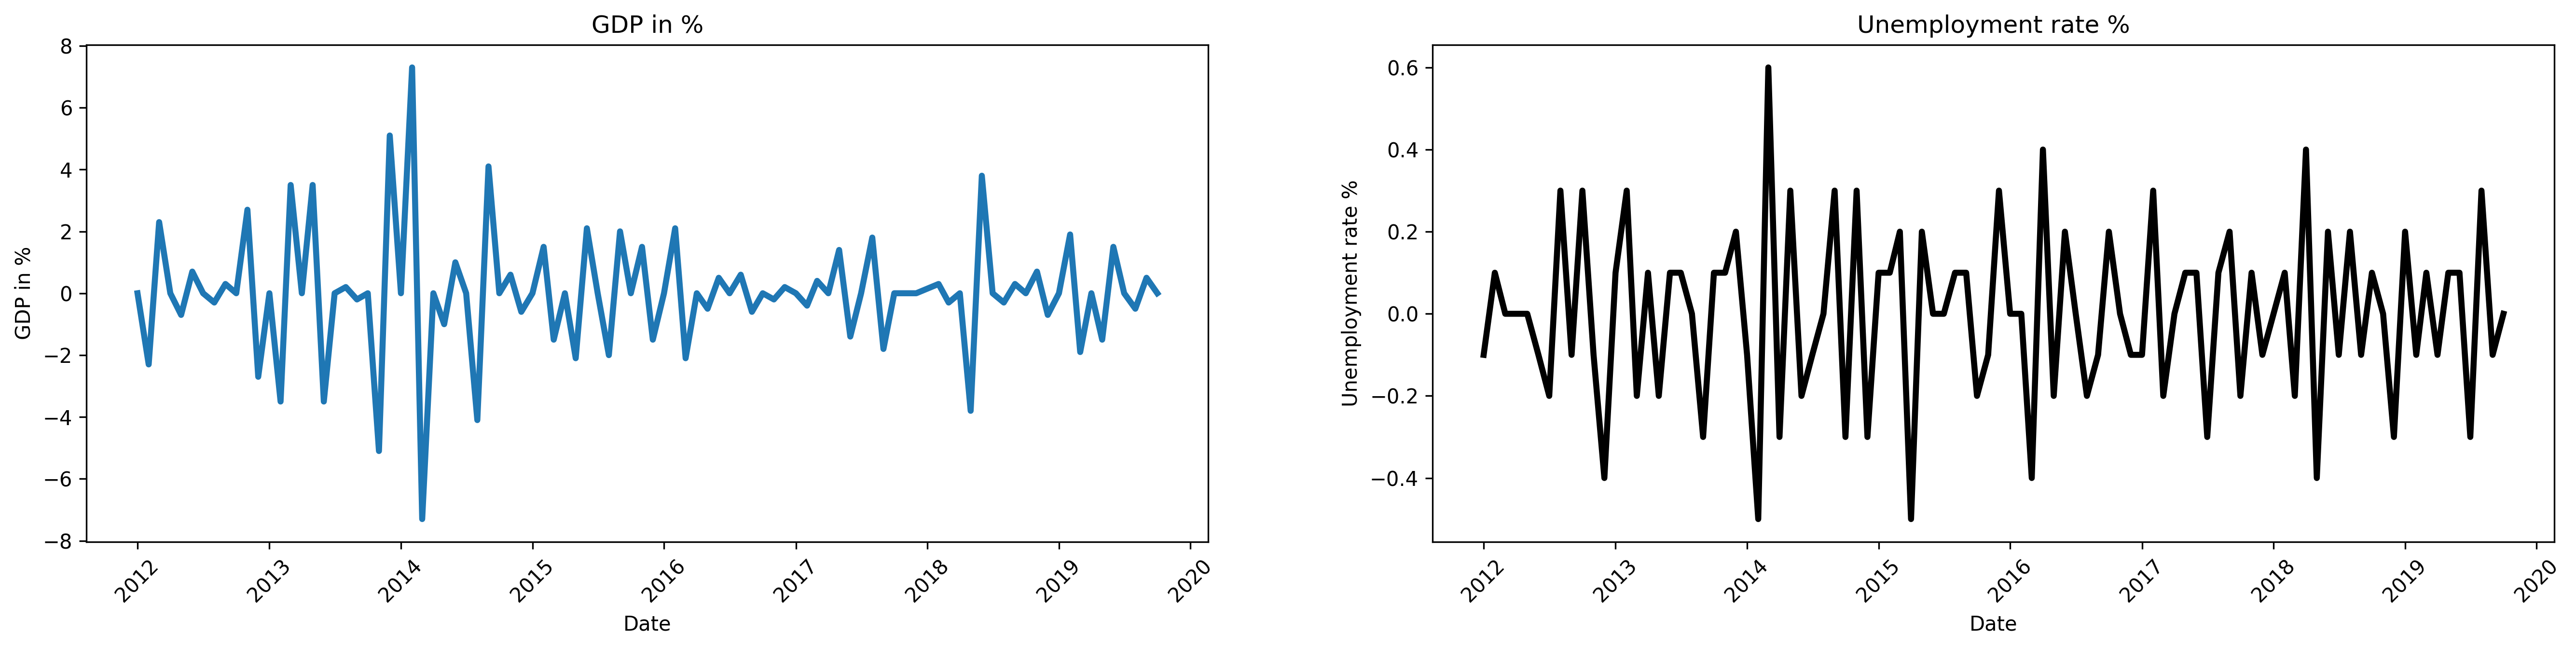

In [ ]:
# Line plots
fig3 = plt.figure(figsize=(22, 10),dpi=300)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
fig1.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax1 = fig3.add_subplot(221)
sns.lineplot(
    data=df_merged_clean_second_difference, 
#     kind="line",
    x=df_merged_clean_second_difference.index, 
    y="Gross Domestic Product",
    ax = ax1,
    linewidth = 3)
plt.xticks(rotation=45) 
plt.ylabel('GDP in %')
plt.xlabel('Date')
plt.title('GDP in %')

ax2 = fig3.add_subplot(222)
sns.lineplot(
    data=df_merged_clean_second_difference, 
    x=df_merged_clean_second_difference.index, 
    y="Unemployment Rate, Percent",
    ax = ax2,
    linewidth = 3,
    color = 'black')
plt.xticks(rotation=45) 
plt.ylabel('Unemployment rate %')
plt.xlabel('Date')
plt.title('Unemployment rate %')

In [ ]:
selected_first = df_merged_clean[['Monthly return','CPI']]
selected_second  = df_merged_clean_first_difference[['Effective Federal Funds Rate']]
data_frames_ = [df_merged_clean_second_difference,selected_first,selected_second]

#Merge all DF into one based on "observation date" using the function melt, keep N/A if any

df_total = reduce(lambda  left,right: pd.merge(left,right,on=['observation_date'],
                                            how='left'), data_frames_)
columns_ = ['CPI','Effective Federal Funds Rate','Unemployment Rate, Percent','Gross Domestic Product']

In [ ]:
x = df_total[columns_]
y = df_total['Monthly return']
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)


Slope: [-0.01420576 -0.05059214  0.03158844 -0.00259651]
Intercept: 0.020868762904639022
Root mean squared error:  0.001826361016062384
R2 score:  0.07633607017498134


In [ ]:
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:         Monthly return   R-squared (uncentered):                   0.137
Model:                            OLS   Adj. R-squared (uncentered):              0.098
Method:                 Least Squares   F-statistic:                              3.518
Date:                Wed, 29 Sep 2021   Prob (F-statistic):                      0.0103
Time:                        15:29:57   Log-Likelihood:                          160.76
No. Observations:                  93   AIC:                                     -313.5
Df Residuals:                      89   BIC:                                     -303.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------